In [1]:
import os
# os.chdir('/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability')
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
from src.generate_data import get_game_data, get_odds_data, get_event_data

%matplotlib notebook

notebook_dir = os.getcwd()
os.chdir(os.path.join(notebook_dir, '..'))
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
root_dir = notebook_dir
data_dir = os.path.join(root_dir, 'data')

In [2]:
cache=True
game_df = get_game_data(cache=cache)
game_df = game_df.sort_values(by='game_date', ascending=False).reset_index(drop=True)
game_codes = game_df.game_code.values
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
played_game_codes = game_df.loc[game_df.game_state_id == 11, 'game_code'].values
unplayed_game_codes = game_df.loc[game_df.game_state_id != 11, 'game_code'].values
assert game_df.loc[~game_df.game_code.isin(unplayed_game_codes)].isna().sum().sum() == 0, 'Unexpected NaN values found in game data frame'
display(HTML(game_df.head(3).to_html(index=False)))
print('Games in sample: {0:d}'.format(game_codes.size))

Running get_game_data... 

get_game_data is returning cached df
get_game_data done in 0 sec.


game_code,game_date,home_team_id,away_team_id,season,home_team_abbrev,away_team_abbrev,week,home_score,away_score,status,game_state_id
2337709,2022-01-09 14:25:00,355,361,2021,Ari,Sea,18,0,0,Pre-Game,1
2337493,2022-01-09 14:25:00,332,339,2021,Den,KC,18,0,0,Pre-Game,1
2337706,2022-01-09 13:25:00,343,359,2021,LAR,SF,18,0,0,Pre-Game,1


Games in sample: 3745


In [3]:
# market_df = get_odds_data(cache=cache)
# prior_df = market_df.drop_duplicates("game_code")
# prior_df = game_df[['game_code',
#                     'game_date',
#                     'home_team_abbrev',
#                     'home_team_id',
#                     'away_team_abbrev',
#                     'away_team_id']].merge(right=prior_df, how='left', on='game_code')
# prior_df = prior_df.set_index('game_code').loc[game_codes].reset_index()
# display(HTML(prior_df.tail(5).to_html(index=False)))
# mask = prior_df.isna().sum(axis=1).values == 0
# print('Market data found for {0:d} games (out of {1:d})'.format(mask.sum(), mask.size))

In [4]:
prior_df = pd.read_csv("data/game_priors.csv")

In [ ]:
events_df.group_by("event_id")

In [5]:
max_away_score = np.max(game_df["away_score"])
max_home_score = np.max(game_df["home_score"])
input_names = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'down', 'ytg']
output_name = 'remaining_exact_score'
events_df = get_event_data(cache=cache)
events_df['remaining_exact_score'] = events_df["away_rest_of_game_score"] + \
                                     (max_away_score + 1) * events_df['home_rest_of_game_score']


Running get_event_data... 

get_event_data is returning cached df
get_event_data done in 1 sec.


In [6]:
full_df = events_df.merge(prior_df, on="game_code")
full_df = full_df[full_df[input_names+[output_name]].notna().all(axis=1)]


In [7]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)


In [8]:
X_train = full_df.loc[~mask_test, input_names]
y_train = full_df.loc[~mask_test, output_name]
X_test = full_df.loc[mask_test, input_names].values
y_test = full_df.loc[mask_test, output_name].values
n_categories = (max_home_score + 1) * (max_away_score + 1)


In [9]:
sample = full_df[input_names]

In [12]:
COMPUTE_PARAMS = (
    {"thread_count": -1}
)
clf = MLPClassifier(
    hidden_layer_sizes=[10,5],
    activation='relu',
    solver='adam',
    alpha=0.0001,  # L2 regularization parameter
    learning_rate_init=0.001,
    batch_size=128,
    random_state=1,
    max_iter=50, #50
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    verbose=True).fit(X_train, y_train)


Iteration 1, loss = 5.42015643


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.101449
Iteration 2, loss = 5.17272574


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.103613
Iteration 3, loss = 5.13312210


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.103772
Iteration 4, loss = 5.11148813


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.103527
Iteration 5, loss = 5.10450908


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.103080
Iteration 6, loss = 5.10121420


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.104840
Iteration 7, loss = 5.09935586


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.104450
Iteration 8, loss = 5.09766096


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.104927
Iteration 9, loss = 5.09475742


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105345
Iteration 10, loss = 5.09197088


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.103585
Iteration 11, loss = 5.08807605


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.106139
Iteration 12, loss = 5.08452276


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.104768
Iteration 13, loss = 5.07794967


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105461
Iteration 14, loss = 5.07432339


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.102574
Iteration 15, loss = 5.06947974


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105836
Iteration 16, loss = 5.06461321


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105489
Iteration 17, loss = 5.06065259


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.106384
Iteration 18, loss = 5.05620426


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105417
Iteration 19, loss = 5.05475853


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105937
Iteration 20, loss = 5.04964353


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.107019
Iteration 21, loss = 5.04731108


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.106471
Iteration 22, loss = 5.04405781


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.106240
Iteration 23, loss = 5.04221653


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105951
Iteration 24, loss = 5.03954527


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.106225
Iteration 25, loss = 5.03403651


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.105648
Iteration 26, loss = 5.02419499


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Validation score: 0.107005
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


In [ ]:
# test_pool = Pool(X_test, y_test)
# FIT_PARAMS = {
#     "verbose": 1,
#     "early_stopping_rounds": 5,
#     "use_best_model": True,
# }
# COMPUTE_PARAMS = (
#     {"devices": "0:1", "thread_count": -1}
# )
# PARAMS = {
#     # "n_estimators": 10,
#     "num_trees": 1,
#     "auto_class_weights": "Balanced",
#     # "loss_function": JITRmseObjective(),
#     # "eval_metric": JITRmseMetric(),
#     **COMPUTE_PARAMS,
# }
# clf = CatBoostClassifier(
#             random_state=42,
#             **PARAMS,
# ).fit(X_train, y_train, **FIT_PARAMS)


In [13]:
os.system('say "done"')

0

In [16]:
def get_model_outputs(model, input_data, running_scores):
    raw_output = model.predict_proba(input_data)
    # Exact score outputs    
    score_probs = np.zeros((input_data.shape[0], n_categories))
    score_probs[:, clf.classes_] = raw_output
    # 1X2 prediction & team score outputs
    outcome_probs = np.zeros((input_data.shape[0], 3))
    home_score_probs = np.zeros((input_data.shape[0], max_home_score + 1))
    away_score_probs = np.zeros((input_data.shape[0], max_away_score + 1))
    for home_score in range(max_home_score + 1):
        ft_home_score = home_score + running_scores[:, 0]
        for away_score in range(max_away_score + 1):            
            ft_away_score = away_score + running_scores[:, 1]
            remaining_prob = score_probs[:, away_score + (max_away_score + 1) * home_score]
            # 1X2 - Home win
            outcome_probs[:, 0] = np.where(ft_home_score > ft_away_score,
                                           outcome_probs[:, 0] + remaining_prob,
                                           outcome_probs[:, 0])
            # 1X2 - Draw
            outcome_probs[:, 1] = np.where(ft_home_score == ft_away_score,
                                           outcome_probs[:, 1] + remaining_prob,
                                           outcome_probs[:, 1])
            # 1X2 - Away win
            outcome_probs[:, 2] = np.where(ft_home_score < ft_away_score,
                                           outcome_probs[:, 2] + remaining_prob,
                                           outcome_probs[:, 2])
            # Team scores
            home_score_probs[:, home_score] += remaining_prob
            away_score_probs[:, away_score] += remaining_prob
    return {
        'remaining_score': score_probs,
        'home_score': home_score_probs,
        'away_score': away_score_probs,
        'ft_outcome': outcome_probs
    }

In [19]:
example_game_code = np.random.choice(test_game_codes)
example_indices = [0, 1, -2, -1]
example_input = full_df.loc[full_df.game_code == example_game_code, input_names].values[example_indices]
full_df = full_df.sort_values(["game_code", "nevent"], ascending=True)
example_running_score = full_df.loc[full_df.game_code == example_game_code,
                                    ['home_start_score', 'away_start_score']].values[example_indices]
example_output = get_model_outputs(clf, example_input, example_running_score)
print('\nExample input data:')
display(HTML(pd.DataFrame(data=example_input, columns=input_names).to_html(index=False)))

# print('\nExample outputs (exact score):')
# print(example_output['remaining_score'][0][0:10])
# print(example_output['remaining_score'][0][10:20])
# print(example_output['remaining_score'][0][20:30])

print('\nExample outputs (home team score):')
display(HTML(pd.DataFrame(data=example_output['home_score'], columns=np.arange(max_home_score + 1)).to_html(index=False)))

print('\nExample outputs (away team score):')
display(HTML(pd.DataFrame(data=example_output['away_score'], columns=np.arange(max_away_score + 1)).to_html(index=False)))

print('\nExample outputs (1X2):')
display(HTML(pd.DataFrame(data=example_output['ft_outcome'], columns=['home win', 'draw', 'away win']).to_html(index=False)))


Example input data:


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,play_start_time,yd_from_goal,down,ytg
0.433583,0.564432,0.0,0.0,0.0,1.0,900.0,65.0,0.0,-1.0
0.433583,0.564432,1.0,0.0,0.0,1.0,900.0,92.0,0.0,-1.0
0.433583,0.564432,1.0,16.0,41.0,4.0,23.0,63.0,2.0,8.0
0.433583,0.564432,1.0,16.0,41.0,4.0,0.0,54.0,1.0,-1.0



Example outputs (home team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0.008568,0.000004,0.000269,0.015337,0.000006,0.000415,0.015037,0.022512,0.003081,0.011634,0.039997,0.004027,0.009801,0.039213,0.031609,0.009789,0.038300,0.068450,0.009330,0.022085,0.068069,0.035756,0.014018,0.051902,0.065661,0.011914,2.474631e-02,0.055066,0.031021,1.379509e-02,3.434880e-02,4.893808e-02,8.443529e-03,1.562196e-02,0.034774,2.061137e-02,7.017763e-03,1.514830e-02,2.560310e-02,3.547837e-03,6.990522e-03,1.079314e-02,7.874559e-03,4.819867e-03,4.565581e-03,9.374703e-03,1.440949e-03,2.241958e-03,4.045171e-03,4.232313e-03,3.441699e-04,1.961029e-03,1.806555e-03,4.734868e-04,4.249371e-04,1.516080e-03,5.288199e-04,1.072742e-04,2.189869e-04,5.204773e-04,4.619103e-11,0.0,2.500571e-04
0.007183,0.000002,0.000218,0.013242,0.000002,0.000315,0.013624,0.019161,0.002543,0.010462,0.036252,0.003272,0.009236,0.038363,0.028416,0.008370,0.037840,0.067727,0.007944,0.022286,0.071728,0.034138,0.012980,0.056041,0.069617,0.010731,2.620463e-02,0.059614,0.030120,1.355590e-02,3.730866e-02,5.362086e-02,8.067711e-03,1.561272e-02,0.037680,2.062983e-02,6.822425e-03,1.511547e-02,2.697941e-02,3.182318e-03,6.799183e-03,1.102432e-02,7.816188e-03,4.701165e-03,4.504399e-03,9.778294e-03,1.322443e-03,2.252139e-03,3.892757e-03,4.135312e-03,3.006409e-04,1.807531e-03,1.671064e-03,4.238294e-04,3.782125e-04,1.467607e-03,4.972522e-04,9.084677e-05,2.109514e-04,4.754863e-04,4.945179e-11,0.0,2.433293e-04
0.896229,0.000005,0.001790,0.007403,0.000002,0.000049,0.010339,0.060057,0.018468,0.000294,0.001283,0.000884,0.000054,0.000526,0.001742,0.000444,0.000082,0.000076,0.000147,0.000004,0.000026,0.000045,0.000010,0.000004,0.000015,0.000010,8.825651e-07,0.000002,0.000005,3.949471e-07,4.760831e-07,6.617504e-08,9.487706e-07,3.518253e-08,0.000002,3.012434e-07,7.224356e-07,1.368013e-07,1.239348e-08,4.594063e-08,8.177519e-08,1.341449e-09,2.139265e-07,3.577418e-09,5.658360e-11,2.286257e-10,2.713273e-10,2.900092e-14,1.052837e-08,7.538657e-09,1.146084e-13,1.739045e-07,3.930568e-09,1.075340e-13,4.589137e-23,1.498908e-13,5.808416e-10,2.146531e-10,3.523738e-25,5.278344e-14,6.860108e-14,0.0,6.832750e-10
0.887443,0.000005,0.001921,0.007998,0.000003,0.000056,0.011193,0.064864,0.019951,0.000340,0.001474,0.001007,0.000065,0.000614,0.002021,0.000520,0.000099,0.000093,0.000176,0.000004,0.000032,0.000055,0.000013,0.000005,0.000019,0.000012,1.144884e-06,0.000002,0.000006,5.069325e-07,6.171262e-07,8.762713e-08,1.186074e-06,5.146070e-08,0.000003,3.964154e-07,8.917572e-07,1.806153e-07,1.665009e-08,6.019322e-08,1.126452e-07,1.851502e-09,2.862796e-07,4.995280e-09,8.689791e-11,3.214962e-10,3.810458e-10,4.303224e-14,1.399113e-08,1.067444e-08,1.669548e-13,2.372280e-07,5.689576e-09,1.588557e-13,9.321057e-23,2.304688e-13,8.694609e-10,2.828702e-10,7.572052e-25,7.768422e-14,8.543863e-14,0.0,8.717294e-10



Example outputs (away team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0.016227,0.000009,0.000501,0.021149,0.000016,0.001281,0.018469,0.033921,0.002805,0.017214,0.056764,0.003520,0.012926,0.052930,0.044995,0.008780,0.038192,0.085230,0.009939,0.020719,0.067905,0.038910,1.241898e-02,4.695581e-02,0.063665,1.196590e-02,2.590577e-02,4.772915e-02,2.749574e-02,9.491749e-03,2.401628e-02,3.743517e-02,7.986714e-03,1.373180e-02,2.839169e-02,1.413044e-02,6.280175e-03,1.237129e-02,1.720219e-02,2.544056e-03,4.055499e-03,1.227830e-02,5.972298e-03,1.788493e-03,2.681140e-03,3.892907e-03,6.358602e-04,6.243263e-04,2.102751e-03,1.638983e-03,1.342839e-04,1.368059e-03,3.428874e-04,7.010563e-07,4.755927e-08,9.746980e-05,1.976334e-05,0.0,0.0,2.465022e-04
0.016267,0.000004,0.000412,0.022046,0.000008,0.001115,0.018534,0.034311,0.002371,0.017256,0.059783,0.002903,0.012837,0.055165,0.044556,0.007972,0.038111,0.089083,0.008748,0.020122,0.071106,0.037968,1.139105e-02,4.850943e-02,0.065586,1.074228e-02,2.557850e-02,4.842288e-02,2.640267e-02,8.581727e-03,2.369005e-02,3.703653e-02,7.264791e-03,1.282311e-02,2.829598e-02,1.314787e-02,5.766289e-03,1.196347e-02,1.675297e-02,2.297415e-03,3.867979e-03,1.160843e-02,5.552262e-03,1.597793e-03,2.405236e-03,3.524093e-03,5.561680e-04,5.389173e-04,1.932883e-03,1.514551e-03,1.165543e-04,1.248410e-03,2.934302e-04,3.359258e-07,1.960897e-08,8.193909e-05,1.492177e-05,0.0,0.0,2.138420e-04
0.892329,0.000012,0.001269,0.058314,0.000014,0.000156,0.004822,0.035104,0.002191,0.000267,0.002750,0.000243,0.000024,0.000213,0.001976,0.000045,0.000010,0.000149,0.000013,0.000006,0.000007,0.000077,9.861170e-07,3.536274e-07,0.000004,1.220678e-07,1.107086e-08,3.066513e-07,8.216549e-07,1.533802e-07,1.668794e-07,2.367922e-07,3.564226e-09,4.368079e-08,2.505581e-08,2.281100e-08,1.897852e-08,1.626224e-09,2.867967e-08,2.975844e-12,2.379029e-12,2.492987e-08,1.316438e-09,3.031461e-13,2.797714e-11,1.156266e-09,7.893890e-14,5.944018e-14,7.323465e-11,9.265850e-14,3.412426e-14,2.731366e-14,6.155868e-16,1.668324e-13,6.832066e-10,2.696174e-07,6.367023e-18,0.0,0.0,1.423904e-17
0.883744,0.000014,0.001382,0.062171,0.000016,0.000178,0.005362,0.038040,0.002406,0.000312,0.003173,0.000281,0.000028,0.000254,0.002259,0.000053,0.000012,0.000178,0.000016,0.000007,0.000009,0.000093,1.260833e-06,4.589395e-07,0.000005,1.604924e-07,1.487047e-08,4.022707e-07,1.042815e-06,2.038242e-07,2.151149e-07,3.081083e-07,4.703606e-09,5.997979e-08,3.483130e-08,3.018945e-08,2.604742e-08,2.197814e-09,3.798960e-08,4.619842e-12,3.427580e-12,3.341530e-08,1.872513e-09,4.306171e-13,4.154345e-11,1.640774e-09,1.164532e-13,8.715527e-14,1.145060e-10,1.361609e-13,5.036249e-14,4.045590e-14,9.962304e-16,2.443862e-13,8.716443e-10,3.201684e-07,1.076320e-17,0.0,0.0,2.380978e-17



Example outputs (1X2):


home win,draw,away win
0.561813,0.027462,0.410725
0.583585,0.026634,0.389780
0.000003,0.000002,0.999995
0.000004,0.000003,0.999994


In [23]:
import pickle

pickle.dump(clf, open("models/game_score.sav", 'wb'))

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_55444/2551031834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} v {2}'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev) for _, i in game_info_df.iterrows()]


<IPython.core.display.Javascript object>


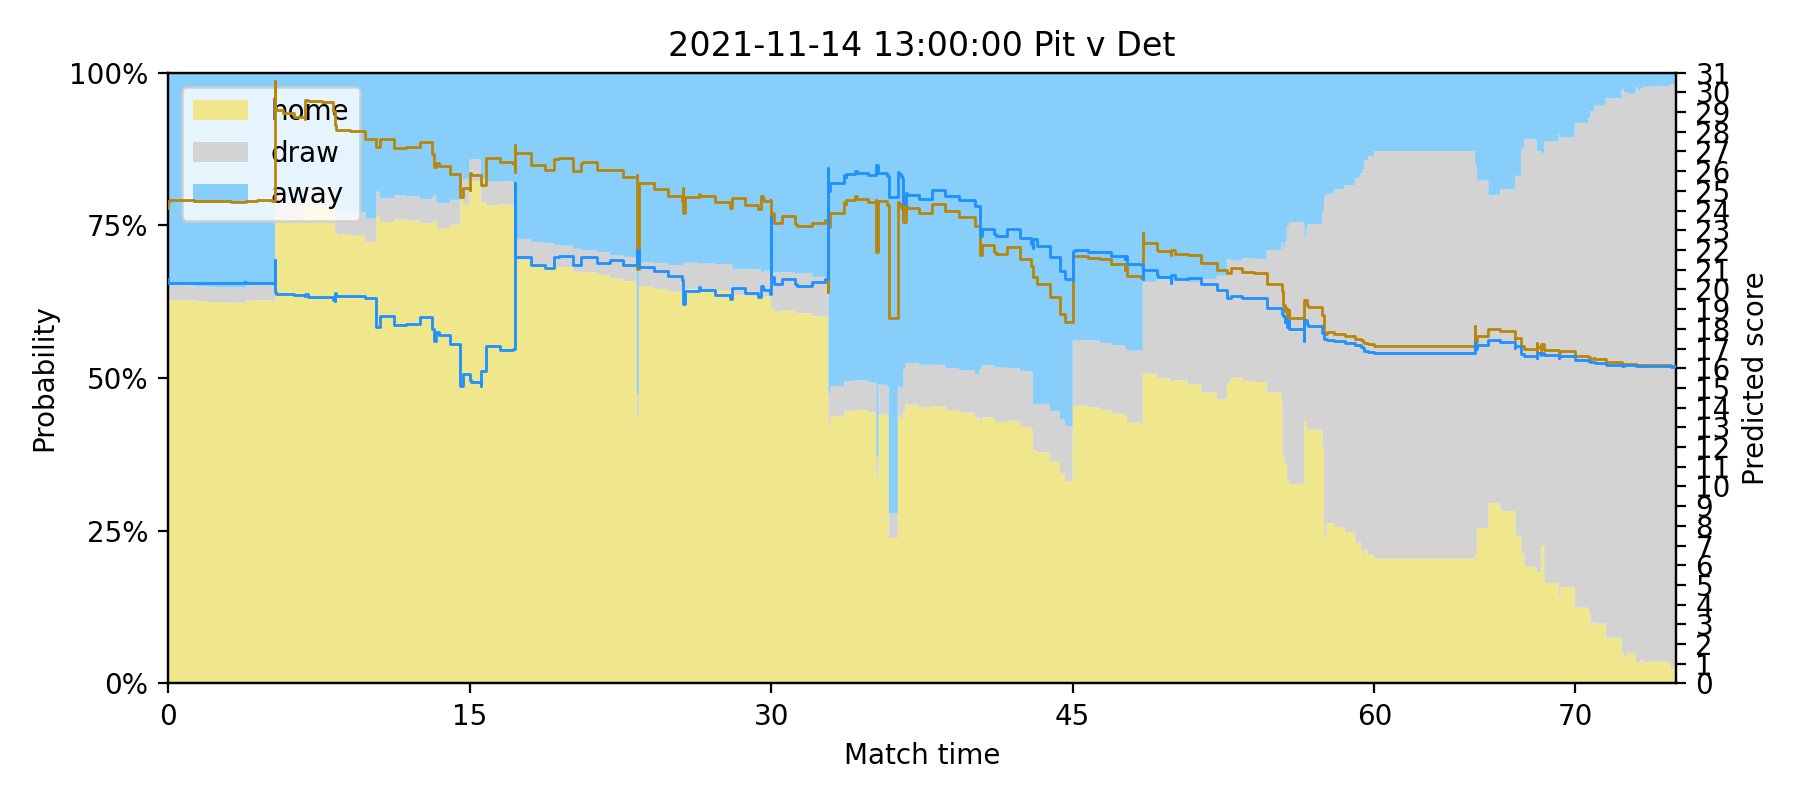

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_55444/2551031834.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_55444/2551031834.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv

In [21]:
# game_info_df = pd.read_csv(os.path.join(data_dir, 'opta_game_list.csv'), usecols=['game_code', 'game_date', 'home_team_name', 'away_team_name'])
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df['game_description'] = ['{0} {1} v {2}'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')

    x_tick_pos = (60 * np.arange(0, 61, 15)).tolist() + (60 * (np.arange(70, 71, 10))).tolist()
    x_tick_str = np.arange(0, 61, 15).astype(str).tolist() + (np.arange(70, 71, 10)).astype(str).tolist()
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, max_score + 0.5))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

In [ ]:
plot_input =full_df[full_df["game_code"]==2337537][input_names].iloc[85:87].values
plot_running_score = full_df.loc[full_df.game_code == 2337537, ['home_start_score', 'away_start_score']].iloc[85:87].values
model_out = get_model_outputs(clf, plot_input, plot_running_score)
for elements in model_out:
    model_out[elements] = model_out[elements].tolist()

In [ ]:
with open(os.path.join(data_dir, 'model_outputs.json'), 'w') as f:
    json.dump(model_out, f)

In [ ]:
full_df[full_df.game_code ==2337702]

In [ ]:
np.max(game_df["away_score"])

In [ ]:
full_df[["nevent", "play_start_time"]]

In [ ]:
os.system('say "done notebook"')
